<a href="https://colab.research.google.com/github/Amdev-5/Natural-Language-Processing-with-Disaster-Tweets/blob/main/Predicting_Disaster_Tweetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Importing Libraries**

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**2. Loading the Data**

In [2]:
tweet = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


**EXPLORATORY DATA ANALYSIS OF TWEETS**

1.Analysis the character level - count the number of characters
2. Analysis the word level- count the number of words
3. Amalysis the sentence level

** 1. Number of Character in tweets**

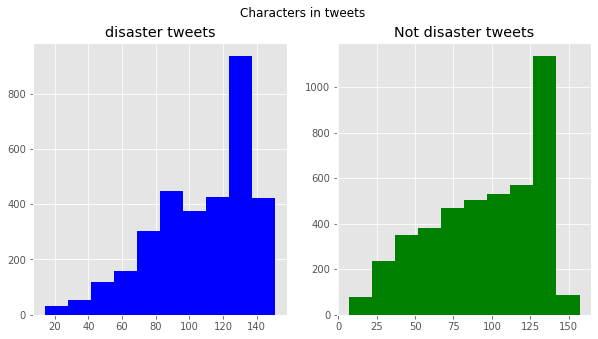

In [3]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

** 2. Number of words in a tweet**

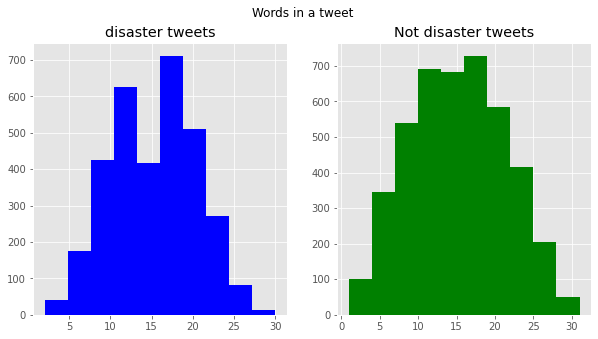

In [4]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

**3. Average word length in a tweet**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each tweet')

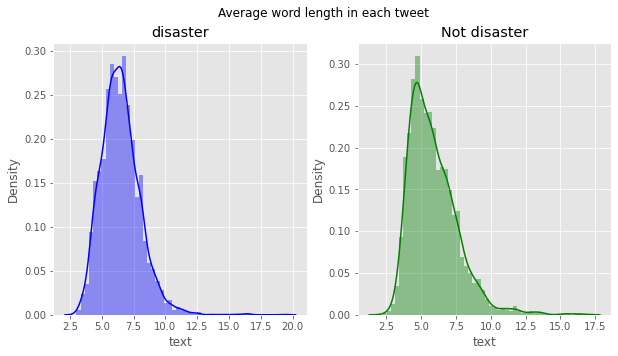

In [5]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title('disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [6]:
def create_corpus(target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

**4. Common stopwords in tweets**

In [7]:
# Analyzing tweet with class 0
corpus = create_corpus(0)
dic = defaultdict(int)
for word in corpus:
  if word in stop:
    dic[word]+=1

top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

<BarContainer object of 10 artists>

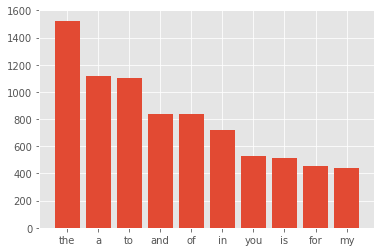

In [8]:
x,y=zip(*top)
plt.bar(x,y)

Now, analyzing tweets with class 1

<BarContainer object of 10 artists>

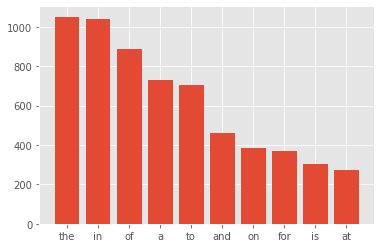

In [9]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    


x,y=zip(*top)
plt.bar(x,y)

Noticed, in class 0 the followed by 0 whereas in class 1 the followed by in

**Analyzing punctuations**

First let's check tweets indicating real disaster.

<BarContainer object of 18 artists>

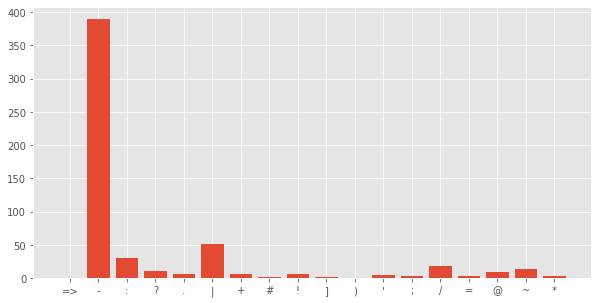

In [10]:
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

**Common Words**

In [11]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

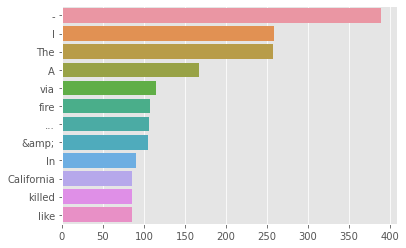

In [12]:
sns.barplot(x=y,y=x)

**Ngram Analysis**


Let's check the most common bigram in tweets by bigram (n=2)

In [13]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

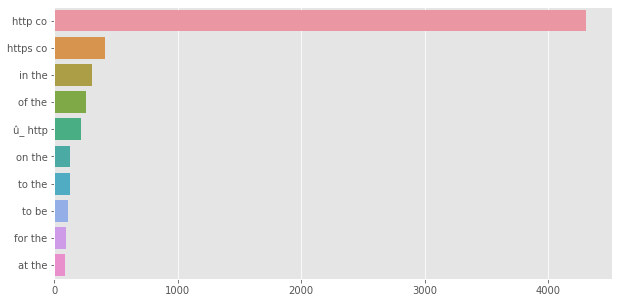

In [14]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

**Data Cleaning**

Since We are working on twitter tweet analysis. It is need to be cleaned such as spelling correction, removing punctuation, removing html tage etc

In [15]:
df=pd.concat([tweet,test])
df.shape

(10876, 5)

**Removing URLs**

In [16]:
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

In [17]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

'New competition launched :'

In [18]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

**Removing HTML tags**

In [19]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [20]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [21]:
df['text']=df['text'].apply(lambda x : remove_html(x))

**Removing Emojis**

In [22]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [23]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

**Removing Punctuations**

In [24]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))

I am a king


In [25]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

**Spelling Correction**

Correcting Spelling using pyspellchecker

In [26]:
!pip install pyspellchecker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.7 MB 16.9 MB/s 


In [27]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "corect me plese"
correct_spellings(text)

'correct me plese'

In [28]:
#df['text']=df['text'].apply(lambda x : correct_spellings(x)#)

**Glove for Vectorization**

Using Gloving pretrained corpus model to represent our words. It is availabale in 3 varities :50D, 100D and 200 Dimensional. We will try 100 D here

In [29]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [30]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [31]:
corpus = create_corpus(df)

100%|██████████| 10876/10876 [00:01<00:00, 5929.04it/s]


In [32]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1.0
2,5,NaN,NaN,All residents asked to shelter in place are be...,1.0
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1.0
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1.0


In [33]:
X = df["text"]

**Next Apply Lemmatization**

In [34]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [35]:
from nltk.stem import WordNetLemmatizer

wl = WordNetLemmatizer()
 
# single word lemmatization examples
list1 = ['kites', 'babies', 'dogs', 'flying', 'smiling',
         'driving', 'died', 'tried', 'feet']
for words in list1:
    print(words + " ---> " + wl.lemmatize(words))
    
print(wl.lemmatize('hands, birds cars'))

kites ---> kite
babies ---> baby
dogs ---> dog
flying ---> flying
smiling ---> smiling
driving ---> driving
died ---> died
tried ---> tried
feet ---> foot
hands, birds cars


In [36]:
from nltk.corpus import wordnet
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [37]:
features = df.columns.drop(['id','keyword','target', 'text', 'location'])

**Text Vectorization**

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [39]:
stpwrdlist=['the', 'a', 'an']#Custom list of stopwords 
vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.001, stop_words=stpwrdlist, ngram_range=(1,3)) #stop_words=stpwrdlist

Split df into train and test:

In [40]:
train = df[df['target'].notna()]
test =df[df['target'].isna()]
y = train['target']
train = train.drop('target', axis=1)

Fit vectorizer and transform test set

In [41]:
X = vectorizer.fit_transform(train['text'])

X_test = vectorizer.transform(test['text'])

Concatenate features from vectorizer with previous features

In [42]:
X = np.concatenate((X.toarray(), train[features]), axis=1)

X_test = np.concatenate((X_test.toarray(), test[features]), axis=1)

Split train data into train and validation data

In [50]:
# Test train split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

**Build Neural Network**

In [44]:
# function to calculate f1 score for each epoch
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [45]:
# Bag of Words model
from keras.preprocessing.text import Tokenizer

# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [51]:
# create and apply tokenizer on the training dataset
tokenizer = create_tokenizer(X_train)
X_train_set = tokenizer.texts_to_matrix(X_train, mode = 'freq')

In [52]:
# define the model
def define_model(n_words):
    # define network
    model = Sequential()
    model.add(Dense(128, input_shape=(n_words,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = [get_f1])
    # summarize defined model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [54]:
from tensorflow.keras.utils import plot_model

In [55]:
# create the model
n_words = X_train_set.shape[1]
model = define_model(n_words)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               2012928   
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,013,057
Trainable params: 2,013,057
Non-trainable params: 0
_________________________________________________________________


In [56]:
#fit network
model.fit(X_train_set,y_train,epochs=10,verbose=2)

Epoch 1/10
191/191 - 5s - loss: 0.6258 - get_f1: 0.3359 - 5s/epoch - 29ms/step
Epoch 2/10
191/191 - 2s - loss: 0.4394 - get_f1: 0.7719 - 2s/epoch - 13ms/step
Epoch 3/10
191/191 - 3s - loss: 0.3242 - get_f1: 0.8475 - 3s/epoch - 13ms/step
Epoch 4/10
191/191 - 2s - loss: 0.2472 - get_f1: 0.8857 - 2s/epoch - 13ms/step
Epoch 5/10
191/191 - 2s - loss: 0.1918 - get_f1: 0.9264 - 2s/epoch - 13ms/step
Epoch 6/10
191/191 - 2s - loss: 0.1528 - get_f1: 0.9401 - 2s/epoch - 13ms/step
Epoch 7/10
191/191 - 2s - loss: 0.1233 - get_f1: 0.9558 - 2s/epoch - 13ms/step
Epoch 8/10
191/191 - 2s - loss: 0.1001 - get_f1: 0.9662 - 2s/epoch - 13ms/step
Epoch 9/10
191/191 - 2s - loss: 0.0839 - get_f1: 0.9721 - 2s/epoch - 13ms/step
Epoch 10/10
191/191 - 2s - loss: 0.0721 - get_f1: 0.9769 - 2s/epoch - 13ms/step


In [59]:
# prediction on the test dataset
X_test_set = tokenizer.texts_to_matrix(X_test, mode = 'freq')
y_predict = np.argmax(model.predict(X_test_set), axis=1)

In [63]:
# important metrices
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73       874
         1.0       0.00      0.00      0.00       649

    accuracy                           0.57      1523
   macro avg       0.29      0.50      0.36      1523
weighted avg       0.33      0.57      0.42      1523



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
# apply tokenizer on the test dataset
test_set = tokenizer.texts_to_matrix(test.text, mode = 'freq')

In [66]:
# make predictions on the test dataset
y_test_pred = model.predict(test_set)